# ABOVE AC9 Data Processing  

## Checking Clean Water Blanks

**Authors:** Catherine Kuhn and Elena Terzić   
**Last Updated:** August, 15th, 2018

### Import libraries

In [2]:
### Import the required python libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import glob
import os
import sys
import csv
from scipy import interpolate
from os import listdir
from os.path import isfile, join
import matplotlib.gridspec as gridspec

In [17]:
%cd /Users/Petrichor/Dropbox/AC9_ForAnna/

/Users/Petrichor/Dropbox/AC9_ForAnna


### Functions

#### Gets a list of the subdirectories in a target directory (default is listing subdirectories in the current directory)

In [4]:
def get_subdirectories(directory=os.getcwd()):
    if directory in os.getcwd():
        directories = os.listdir(os.getcwd())
    else:
        directories = os.listdir(os.getcwd()+'/'+directory)
    directories = [subdirectory for subdirectory in directories if not subdirectory.startswith('.')]
    return directories

#### Averages replicates from a list of file names (takes list of files, loads into panda as dataframe, then averages all the dataframes together)

In [5]:
def average_replicates(list_of_files):
    replicates = []
    for filename in list_of_files:
        replicates.append(pd.read_csv(filename, skiprows=0, delimiter = '\t'))
    x = replicates[0]
    for i in range(len(replicates)):
        # if it is the first file in the list of files, just go to the next one
        if i == 0:
            continue
        # if it is the second, third, etc, then add them together and average them
        else:
            x = x + replicates[i]
    # new file is x
    x = x/len(replicates)
    return x

#### Plots absorption/attenuation for multiple replicates

In [6]:
def plotting_absorption(list_of_files, title='Title'):
    j = 0
    x = []
    y = []
    for filename in range(len(list_of_files)):   
            df = pd.read_csv(list_of_files[filename], skiprows = 0, delimiter= '\t')         
            df.reset_index(inplace=True, drop=False)
            df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
            plt.plot('wl','mean',data=df)
            #plt.scatter('wl', 'a_mean', data = df)
            #plt.legend()
            plt.errorbar('wl', 'mean', yerr='std', fmt='k-', linewidth=0.5, data = df) 
            plt.ylabel('a [1/m]')
            plt.title(title)

    return plt

## Read and plot all files in a directory

All_Calibrations_Absorption


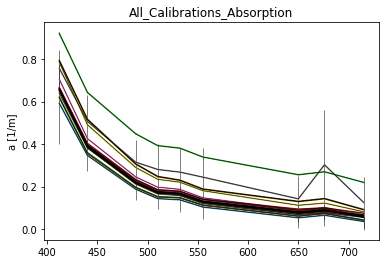

071818_boo_fil_c


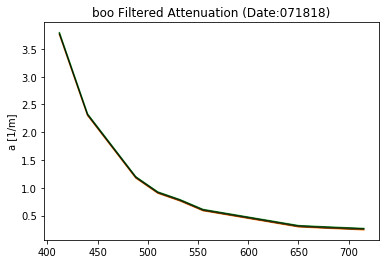

071818_boo_fil_a


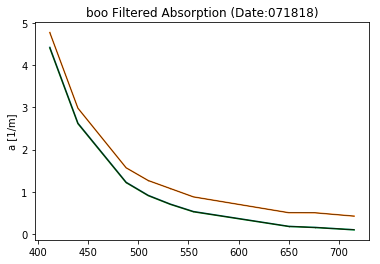

071918_y20_fil_a


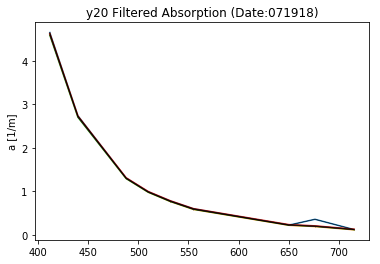

071618_cbr_fil_c


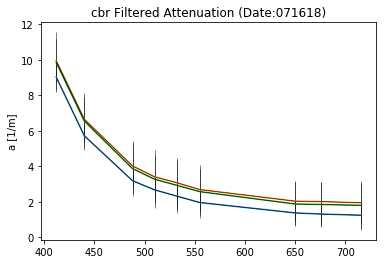

071618_cbr_fil_a


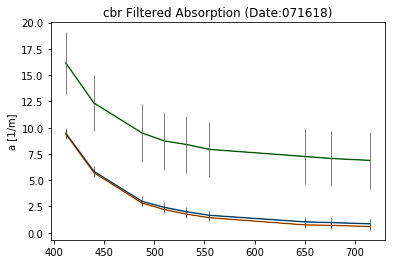

071418_bai_raw_a


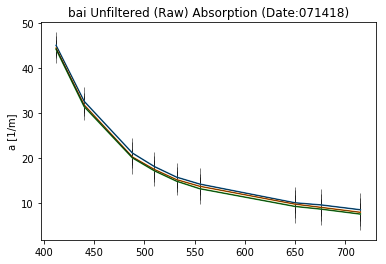

071418_bai_raw_c


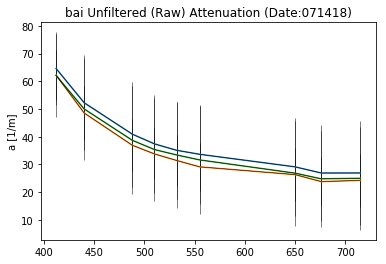

071818_gre_fil_c


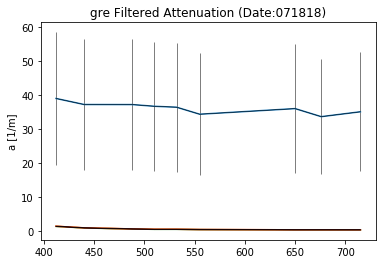

071918_y17_fil_c


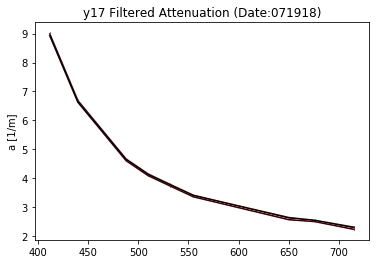

071818_gre_fil_a


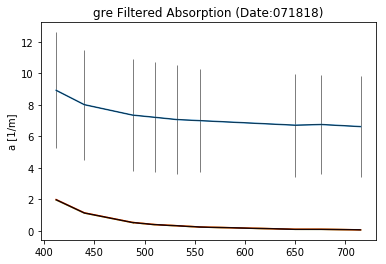

071718_y20_raw_a


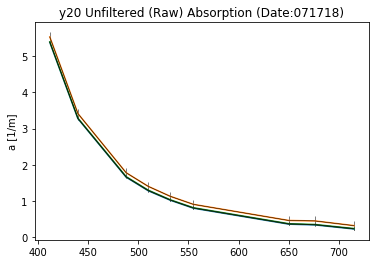

071718_y20_raw_c


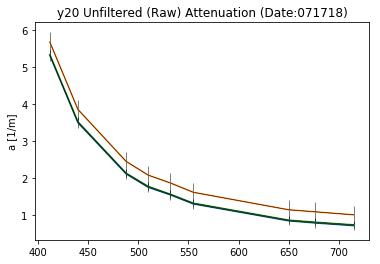

071718_y17_fil_a


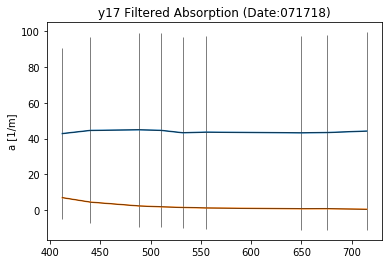

071718_y17_fil_c


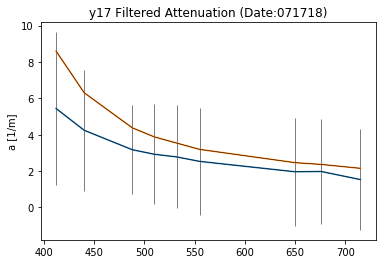

071918_cbr_fil_a


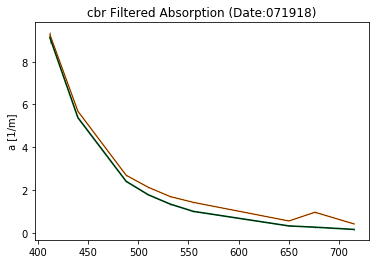

071918_y20_fil_c


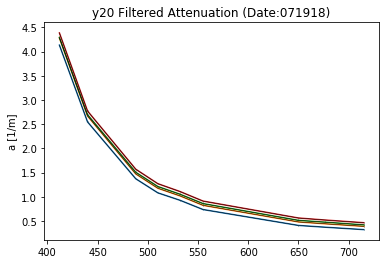

071918_cbr_fil_c


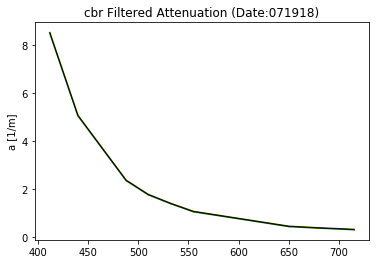

071718_9mi_fil_c


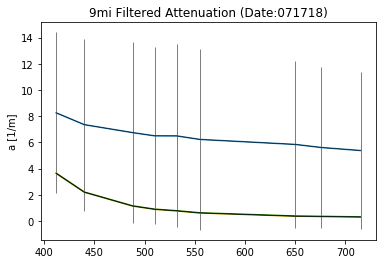

071718_9mi_fil_a


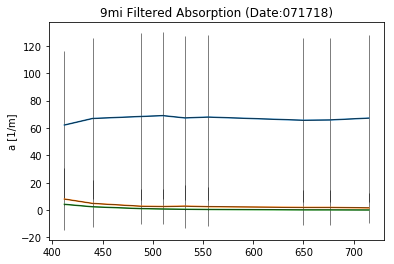

071718_y17_raw_c


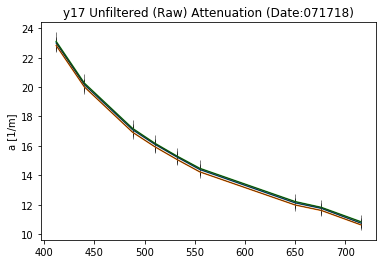

071718_y17_raw_a


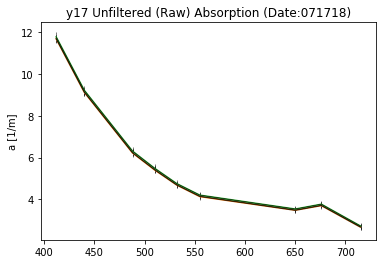

All_Calibrations_Attenuation


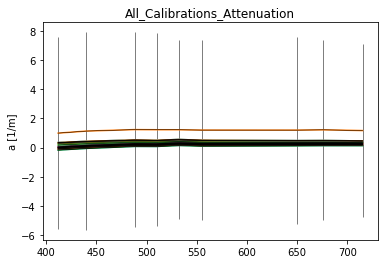

071718_sco_fil_a


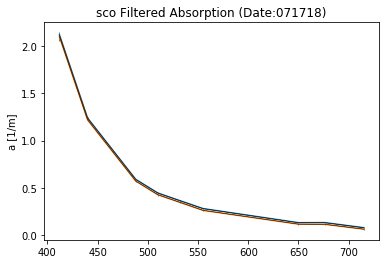

071918_cbr_raw_c


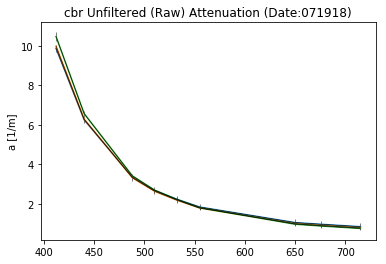

071718_sco_fil_c


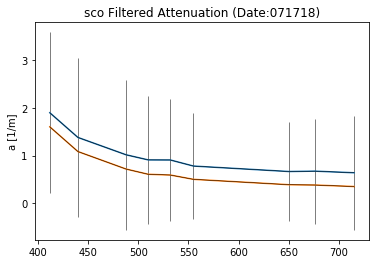

071918_cbr_raw_a


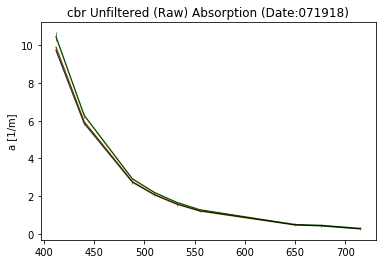

071818_gre_raw_a


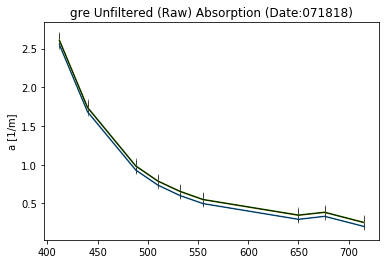

071818_gre_raw_c


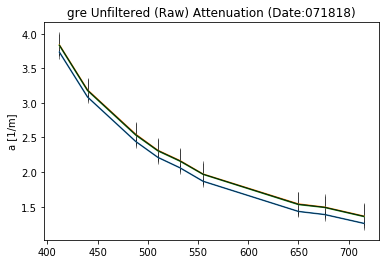

071718_9mi_cal_c


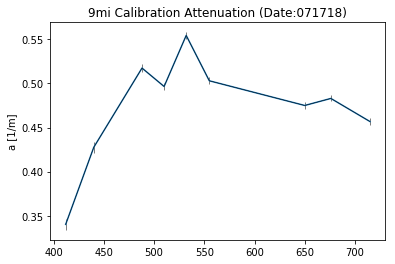

071718_9mi_cal_a


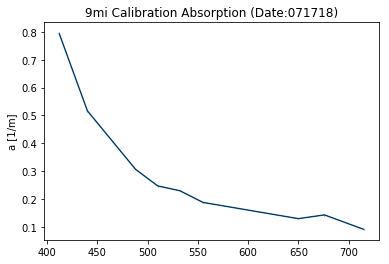

071618_cbr_cal_c


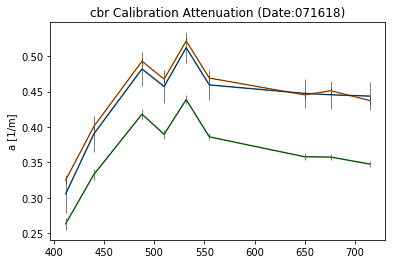

071618_cbr_cal_a


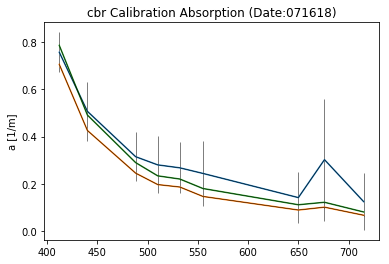

071818_boo_raw_a


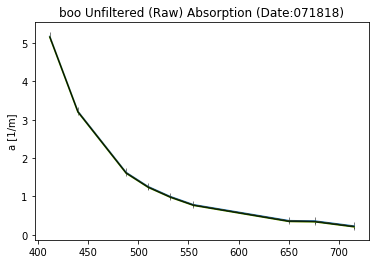

071918_y17_fil_a


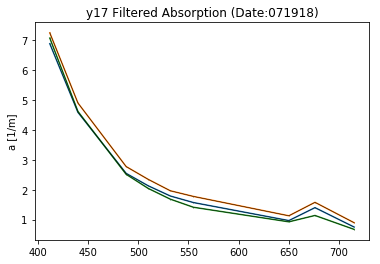

071718_9mi_raw_a


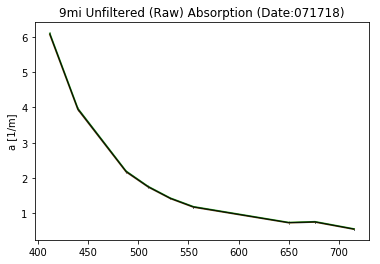

071718_9mi_raw_c


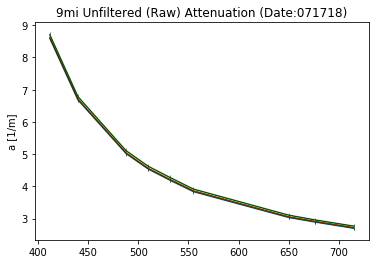

071818_boo_raw_c


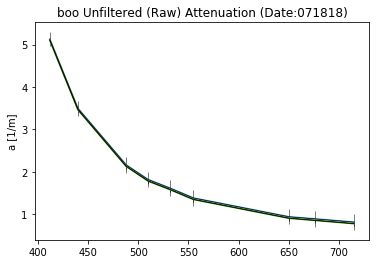

071718_sco_raw_c


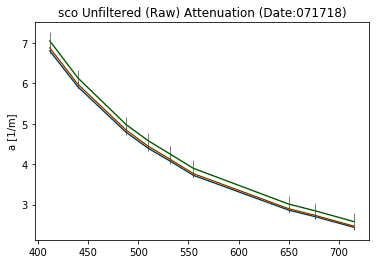

071718_sco_raw_a


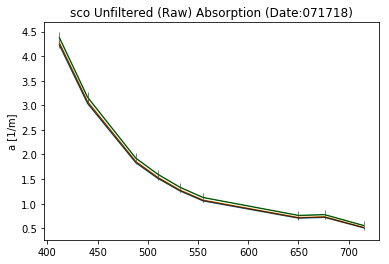

071618_cbr_raw_a


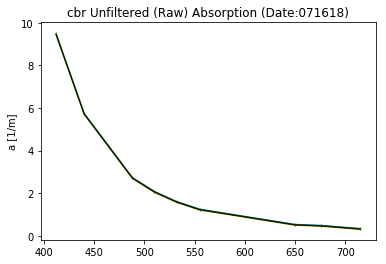

071618_cbr_raw_c


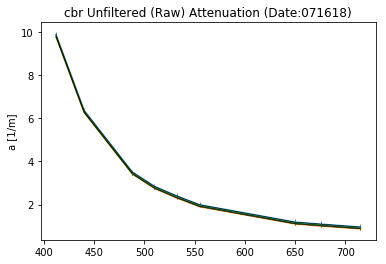

071418_bai_fil_c


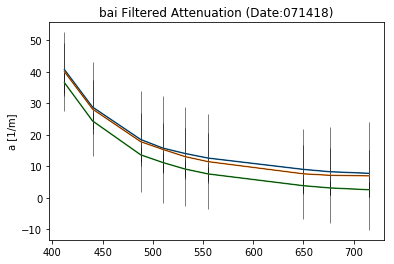

071418_bai_fil_a


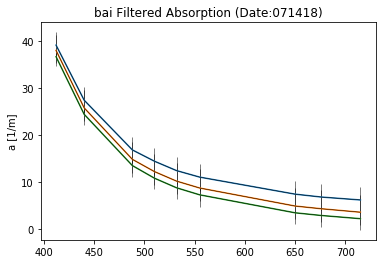

071718_y20_fil_c


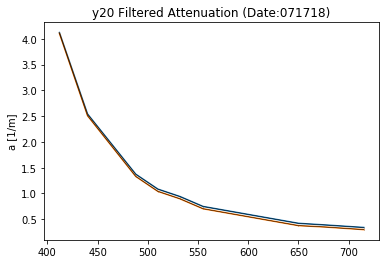

071718_y20_fil_a


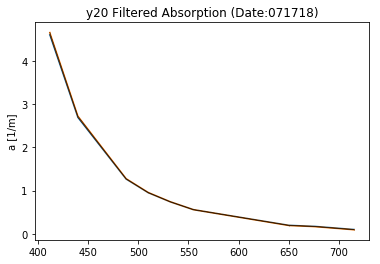

071318_bai_cal_a


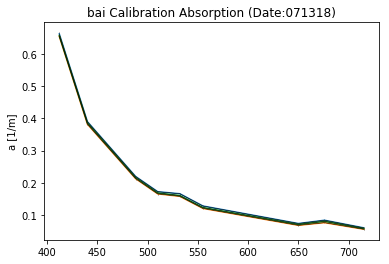

071318_bai_cal_c


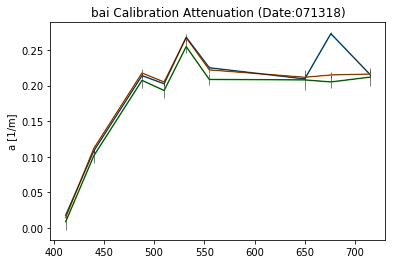

In [7]:
### Where are the files located? define target directory
replicate_files_location = '2_summary_stats'

## In the target directory, go through all the subdirectories. 
dict_of_files = {}
for subdirectory in get_subdirectories(replicate_files_location):
    ### Get all the files in the subdirectory
    plotfiles = sorted(glob.glob(replicate_files_location+'/'+subdirectory+'/*'))
    ## Create an empty dictionary in which to store filenames
    ## Iterate through all the file names in the directory
    for filename in plotfiles:
        #Get file info
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2= filename.split('/')[-1].split('.')[0].split('_')
        if 'cals' in subdirectory:
            if '_a_' in filename:
                unique_id = 'All_Calibrations_Absorption'
            if '_c_' in filename:
                unique_id = 'All_Calibrations_Attenuation'
        else:
            unique_id = '_'.join([Date, Site, Sample_Type, Abs_Type])
        if unique_id not in dict_of_files:
            dict_of_files[unique_id] = [filename]
        else:
            dict_of_files[unique_id].append(filename)

list_of_sampleids = []
dict_of_sampleids_and_plots = {}
for sampleid in dict_of_files:
    list_of_sampleids.append(sampleid)
    print sampleid
    if 'All_Calibrations' in sampleid:
        my_plot = plotting_absorption(dict_of_files[sampleid], title=sampleid)
        dict_of_sampleids_and_plots[sampleid] = my_plot
        my_plot.show()
    else:
        Date, Site, Sample_Type, Abs_Type = sampleid.split('_')
        sample_types = {'fil':"Filtered",'raw':'Unfiltered (Raw)','cal':"Calibration"}
        abs_types = {'a':'Absorption','c':'Attenuation'}
        plottitle = ' '.join([Site,sample_types[Sample_Type],abs_types[Abs_Type],'(Date:'+Date+')'])
        my_plot = plotting_absorption(dict_of_files[sampleid], title=plottitle)
        dict_of_sampleids_and_plots[sampleid] = my_plot
        my_plot.show()

### Average replicates

In [18]:
## Define new directory name for averaged replicates
new_dir_name = '3_averaged_summary_stats'

## Make the new directory for averaged files to go into
current_directory = os.getcwd()
new_dir_path = current_directory+'/'+new_dir_name
if not os.path.exists(new_dir_path):
    os.makedirs(new_dir_path)

## Iterate through unique sample ids (combo of site, date, sample type (raw, etc), and analysis type (a or c))
## Sample ids are keys of dictionary made earlier; entries are lists of files that are replicates of that unique combo
for sampleid in dict_of_files:
    if 'All_Calibrations' in sampleid:
        averages_filename = sampleid + '_average.csv'
    else:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = dict_of_files[sampleid][0].split('/')[-1].split('.')[0].split('_')
        averages_filename = '_'.join([Sensor, Date, Site, Sample_Type, Abs_Type,'average.csv'])
    averaged_file = average_replicates(dict_of_files[sampleid])
    outputdir = new_dir_path + '/' + averages_filename
    averaged_file.to_csv(outputdir, sep='\t')   

## Finding a statistic to check for significant differences between reps....hmm

In [46]:
mydf.to_csv('/Users/Petrichor/Desktop/stat_check.csv')

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



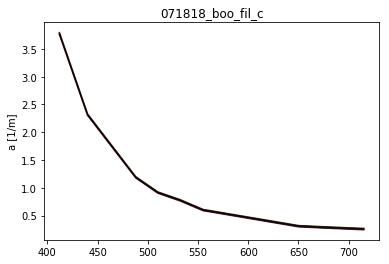

In [42]:
### Generate a dataframe including all reps, with a column denoting the reps
replicates = []
for filename in dict_of_files['071818_boo_fil_c']:
    Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
    df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
    df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
    df['Rep'] = str(Rep)
    #print df
    replicates.append(df)
mydf = pd.concat(replicates)
mydf['wl'].apply(str)
mydf

import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())
plotting_absorption(dict_of_files['071818_boo_fil_c'], title='071818_boo_fil_c').show()

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

data = mydf
md = smf.mixedlm("mean ~ Rep", data, groups=data["wl"])
mdf = md.fit()
print(mdf.summary())

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: mean   
No. Observations: 27      Method:             REML   
No. Groups:       9       Scale:              0.0000 
Min. group size:  3       Likelihood:         54.3647
Max. group size:  3       Converged:          Yes    
Mean group size:  3.0                                
-----------------------------------------------------
          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------
Intercept  1.157    0.389   2.971 0.003  0.394  1.920
Rep[T.2]  -0.011    0.001 -10.307 0.000 -0.013 -0.009
Rep[T.3]   0.012    0.001  11.155 0.000  0.010  0.014
Group Var  1.365  363.935                            



In [31]:
for sampleid in dict_of_files:
    replicates = []
    for filename in dict_of_files[sampleid]:
        Sensor, Date, Site, Sample_Type, Abs_Type, Rep, T1, T2 = filename.split('/')[-1].split('.')[0].split('_')
        df = pd.read_csv(filename, skiprows=0, delimiter = '\t')
        df.rename(columns = {'c_mean':'mean', 'a_mean':'mean', 'c_std':'std','a_std':'std'}, inplace = True)
        df['Rep'] = str(Rep)
        replicates.append(df)
    pd.concat(replicates)
    print replicates

[   Unnamed: 0     wl      mean       std  a_median     a_IQR Rep
0           0  412.0  0.591976  0.192675  0.617685  0.008013   1
1           1  440.0  0.346809  0.071495  0.356950  0.004217   1
2           2  488.0  0.188092  0.049426  0.194855  0.003827   1
3           3  510.0  0.143578  0.048618  0.150565  0.002998   1
4           4  532.0  0.137895  0.058832  0.146140  0.003405   1
5           5  555.0  0.103731  0.053839  0.111425  0.003502   1
6           6  650.0  0.053382  0.049377  0.061460  0.002745   1
7           7  676.0  0.065272  0.048239  0.073180  0.002865   1
8           8  715.0  0.036092  0.039795  0.041720  0.002842   1,    Unnamed: 0     wl      mean       std  a_median    a_IQR Rep
0           0  412.0  0.617012  0.004101   0.61732  0.00548   2
1           1  440.0  0.354836  0.002537   0.35480  0.00348   2
2           2  488.0  0.194446  0.002171   0.19426  0.00292   2
3           3  510.0  0.150545  0.001838   0.15040  0.00236   2
4           4  532.0  0.1459

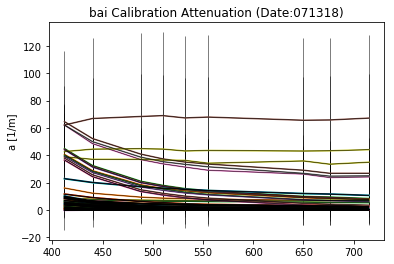

In [65]:
meplot = dict_of_sampleids_and_plots['071818_boo_fil_c']
meplot.show()

In [38]:
df['meow'] = 'cow'

In [39]:
df2['meow'] = 'chow'

In [44]:
df3 = pd.concat([df, df2])
df3

,index,Unnamed: 0,wl,a_mean,a_std,a_median,a_IQR,meow
0,0,0,412.0,0.655130,0.005049,0.65505,0.00704,cow
1,1,1,440.0,0.392627,0.003310,0.39259,0.00465,cow
2,2,2,488.0,0.223430,0.002961,0.22339,0.00405,cow
3,3,3,510.0,0.175499,0.002460,0.17543,0.00349,cow
4,4,4,532.0,0.168416,0.002505,0.16835,0.00337,cow
5,5,5,555.0,0.131495,0.002503,0.13141,0.00348,cow
6,6,6,650.0,0.081328,0.002026,0.08138,0.00270,cow
7,7,7,676.0,0.090519,0.001999,0.09050,0.00264,cow
8,8,8,715.0,0.055449,0.001868,0.05539,0.00256,cow
0,1,1,413.0,1.655130,1.005049,1.65505,1.00704,chow


In [42]:
df

,index,Unnamed: 0,wl,a_mean,a_std,a_median,a_IQR,meow
0,0,0,412.0,0.655130,0.005049,0.65505,0.00704,cow
1,1,1,440.0,0.392627,0.003310,0.39259,0.00465,cow
2,2,2,488.0,0.223430,0.002961,0.22339,0.00405,cow
3,3,3,510.0,0.175499,0.002460,0.17543,0.00349,cow
4,4,4,532.0,0.168416,0.002505,0.16835,0.00337,cow
5,5,5,555.0,0.131495,0.002503,0.13141,0.00348,cow
6,6,6,650.0,0.081328,0.002026,0.08138,0.00270,cow
7,7,7,676.0,0.090519,0.001999,0.09050,0.00264,cow
8,8,8,715.0,0.055449,0.001868,0.05539,0.00256,cow


In [41]:
df2

,index,Unnamed: 0,wl,a_mean,a_std,a_median,a_IQR,meow
0,1,1,413.0,1.655130,1.005049,1.65505,1.00704,chow
1,2,2,441.0,1.392627,1.003310,1.39259,1.00465,chow
2,3,3,489.0,1.223430,1.002961,1.22339,1.00405,chow
3,4,4,511.0,1.175499,1.002460,1.17543,1.00349,chow
4,5,5,533.0,1.168416,1.002505,1.16835,1.00337,chow
5,6,6,556.0,1.131495,1.002503,1.13141,1.00348,chow
6,7,7,651.0,1.081328,1.002026,1.08138,1.00270,chow
7,8,8,677.0,1.090519,1.001999,1.09050,1.00264,chow
8,9,9,716.0,1.055449,1.001868,1.05539,1.00256,chow


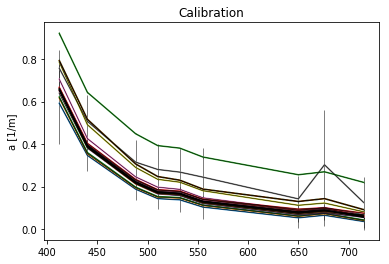

In [59]:
my_plot = plotting_absorption(a_files, title='Calibration')
my_plot.show()

# Dealing with replicates

- read in each file
- group by file name + date + side
- for each group, make a subplot and plot the three replicates
- make a new .csv with summary statistics calculated across the three replicates

In [3]:
%cd /Users/ckuhn/Documents/ABOVE/Data/AC9/ac9_data/2_summary_stats/cal/

/Users/ckuhn/Documents/ABOVE/Data/AC9/ac9_data/2_summary_stats/cal


## Create a dictionary with an entry for each site

In [4]:
from collections import defaultdict

#groups = defaultdict(list)
groups = {}

for filename in sorted(glob.glob('*.csv')):
    basename, extension = os.path.splitext(filename)
    instrument, date, side, site, sample_type, temperature1, temperature2, replicate = basename.split('_')
    unique_id = date + '_' + site
    if unique_id not in groups:
        groups[unique_id] = [filename]
        #print(groups[unique_id])
    else:
        groups[unique_id].append(filename)
 
    
# new dictionary!!
# keys are unique site + date codes
# entries are each file for that site and date
#for i in groups:
    #print(groups[i])

print('list of keys:')
for i in groups:
        print(i)
    
print('')
print 'example entry for a key:', groups['071718_cal']

list of keys:
071818_cal
071618_cal
070718_cal
071318_cal
081618_cal
072118_cal
071918_cal
071718_cal

example entry for a key: ['AC9_071718_can_cal_a_1_T19_0.csv', 'AC9_071718_can_cal_a_2_T19_0.csv', 'AC9_071718_can_cal_a_3_T19_0.csv', 'AC9_071718_can_cal_c_1_T19_0.csv', 'AC9_071718_can_cal_c_2_T19_0.csv', 'AC9_071718_can_cal_c_3_T19_0.csv']


## Sort into a and c sides

In [7]:
a_side_cal = []
c_side_cal = []

for i in groups['081618_cal']:
    if '_c_' in i:
        c_side_cal.append(i)
    else: 
        a_side_cal.append(i)
a_side_cal

['AC9_081618_sea_cal_a_1_T18_5.csv',
 'AC9_081618_sea_cal_a_2_T18_5.csv',
 'AC9_081618_sea_cal_a_3_T18_5.csv',
 'AC9_081618_sea_cal_a_4_T18_5.csv']

## Plot the replicates individually

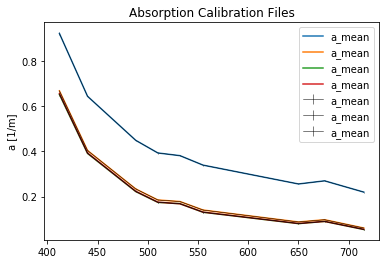

In [8]:
for file in range(len(a_side_cal)):   
        df = pd.read_csv(a_side_cal[file], skiprows = 0, delimiter= '\t')         
        df.reset_index(inplace=True, drop=False)
        plt.plot('wl','a_mean',data=df)
        #plt.scatter('wl', 'a_mean', data = df)
        plt.legend()
        plt.errorbar('wl', 'a_mean', yerr='a_std', fmt='k-', linewidth=0.5, data = df) 
        plt.ylabel('a [1/m]')
        plt.title('a side')
        plt.title('Absorption Calibration Files')
plt.show()

## Average the replicates 

## Plot the new data

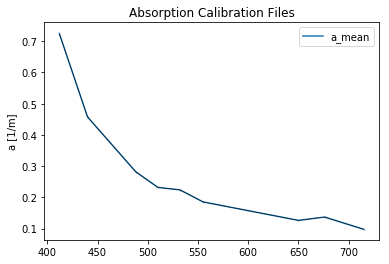

In [10]:
plt.plot('wl','a_mean',data=x)
#plt.scatter('wl', 'a_mean', data = df)
plt.legend()
plt.errorbar('wl', 'a_mean', yerr='a_std', fmt='k-', linewidth=0.5, data = x) 
plt.ylabel('a [1/m]')
plt.title('a side')
plt.title('Absorption Calibration Files')

plt.show()

## Export to a csv

In [11]:
outputname = filename + '.csv'
outputdir = '/Users/ckuhn/Desktop/' + outputname
x.to_csv(outputdir, sep='\t')   

## Graveyard